# Training

This treats the spectrograms of the words like images

In [1]:
# Import all the things we will need
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.data import Dataset
import matplotlib.pyplot as plt

In [2]:
# Load the TensorBoard notebook extension - if you want it inline - this can be a bit flaky...
# %load_ext tensorboard
# %reload_ext tensorboard

In [3]:
# clear out any old logs
!rm -rf ./logs/ 

In [4]:
# List of the words in categorical order
words = [
    'backward',
    'bed',
    'bird',
    'cat',
    'dog',
    'down',
    'eight',
    'five',
    'follow',
    'forward',
    'four',
    'go',
    'happy',
    'house',
    'learn',
    'left',
    'marvin',
    'nine',
    'no',
    'off',
    'on',
    'one',
    'right',
    'seven',
    'sheila',
    'six',
    'stop',
    'three',
    'tree',
    'two',
    'up',
    'visual',
    'wow',
    'yes',
    'zero',
    '_background',
]

In [5]:
# Load up the sprectrograms and labels
training_spectrogram = np.load('training_spectrogram.npz')
validation_spectrogram = np.load('validation_spectrogram.npz')
test_spectrogram = np.load('test_spectrogram.npz')

In [6]:
# extract the data from the files
X_train = training_spectrogram['X']
Y_train_cats = training_spectrogram['Y']
X_validate = validation_spectrogram['X']
Y_validate_cats = validation_spectrogram['Y']
X_test = test_spectrogram['X']
Y_test_cats = test_spectrogram['Y']

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

(array([  991.,   470.,   697.,   536.,   760.,  1466.,   959.,   944.,
          460.,   681.,   897.,   805.,   671.,   823.,   648.,  1302.,
        88060.,  1942.,  1172.,   593.,  1118.,  1088.,  1117.,  1728.,
         1262.,  1911.,  1032.,  1037.,   734.,   921.,   414.,   944.,
          841.,  1611.,  2405.,  5424.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 <BarContainer object of 36 artists>)

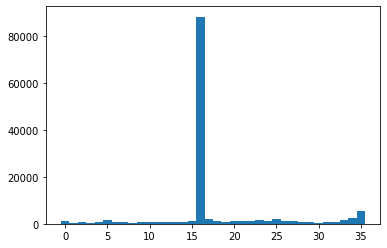

In [7]:
# plot a distribution of the words
plt.hist(Y_train_cats, bins=range(0,len(words)+1), align='left')

In [8]:
unique, counts = np.unique(Y_train_cats, return_counts=True)
print(unique, counts)
dict(zip([words[i] for i in unique], counts))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] [  991   470   697   536   760  1466   959   944   460   681   897   805
   671   823   648  1302 88060  1942  1172   593  1118  1088  1117  1728
  1262  1911  1032  1037   734   921   414   944   841  1611  2405  5424]


{'backward': 991,
 'bed': 470,
 'bird': 697,
 'cat': 536,
 'dog': 760,
 'down': 1466,
 'eight': 959,
 'five': 944,
 'follow': 460,
 'forward': 681,
 'four': 897,
 'go': 805,
 'happy': 671,
 'house': 823,
 'learn': 648,
 'left': 1302,
 'marvin': 88060,
 'nine': 1942,
 'no': 1172,
 'off': 593,
 'on': 1118,
 'one': 1088,
 'right': 1117,
 'seven': 1728,
 'sheila': 1262,
 'six': 1911,
 'stop': 1032,
 'three': 1037,
 'tree': 734,
 'two': 921,
 'up': 414,
 'visual': 944,
 'wow': 841,
 'yes': 1611,
 'zero': 2405,
 '_background': 5424}

In [9]:
Y_train = [1 if y == words.index('marvin') else 0 for y in Y_train_cats]
Y_validate = [1 if y == words.index('marvin') else 0 for y in Y_validate_cats]
Y_test = [1 if y == words.index('marvin') else 0 for y in Y_test_cats]

(array([40404., 88060.]), array([0, 1, 2]), <BarContainer object of 2 artists>)

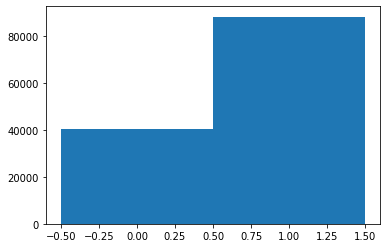

In [10]:
plt.hist(Y_train, bins=range(0,3), align='left')

In [11]:
# create the datasets for training
batch_size = 30

train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
).repeat(
    count=-1
).shuffle(
    len(X_train)
).batch(
    batch_size
)

validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(X_validate.shape[0])

test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))

2023-04-23 22:30:21.451796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31009 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


In [12]:
# model = Sequential([
#     Conv2D(4, 3, 
#            padding='same',
#            activation='relu',
#            kernel_regularizer=regularizers.l2(0.001),
#            name='conv_layer1',
#            input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
#     MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
#     Conv2D(4, 3, 
#            padding='same',
#            activation='relu',
#            kernel_regularizer=regularizers.l2(0.001),
#            name='conv_layer2'),
#     MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
#     Flatten(),
#     Dropout(0.2),
#     Dense(
#         40,
#         activation='relu',
#         kernel_regularizer=regularizers.l2(0.001),
#         name='hidden_layer1'
#     ),
#     Dense(
#         1, 
#         activation='sigmoid',
#         kernel_regularizer=regularizers.l2(0.001),
#         name='output'
#     )
# ])

model = Sequential([
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
#     MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    tf.keras.layers.Reshape((IMG_WIDTH, 43*4)),
    tf.keras.layers.GRU(32, dropout=0.3),
    Dense(
        32,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
#     Dropout(0.2),
#     Dense(
#         32,
#         activation='relu',
#         kernel_regularizer=regularizers.l2(0.001),
#         name='hidden_layer2'
#     ),
    Dense(
        1, 
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 149, 43, 4)        40        
_________________________________________________________________
reshape (Reshape)            (None, 149, 172)          0         
_________________________________________________________________
gru (GRU)                    (None, 32)                19776     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 20,905
Trainable params: 20,905
Non-trainable params: 0
_________________________________________________________________


In [13]:
epochs=30

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data

In [14]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2023-04-23 22:30:33.401372: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-04-23 22:30:33.401430: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-04-23 22:30:33.401513: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-04-23 22:30:33.881942: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-04-23 22:30:33.882216: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


# Train model

In [15]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint-v2.model",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=1,
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)

Epoch 1/30


2023-04-23 22:30:39.427120: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-23 22:30:43.384765: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


   1/4282 [..............................] - ETA: 9:29:58 - loss: 0.5956 - accuracy: 0.7667

2023-04-23 22:30:46.010434: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-04-23 22:30:46.010498: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   3/4282 [..............................] - ETA: 43:26 - loss: 0.6879 - accuracy: 0.6778  

2023-04-23 22:30:47.008664: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-04-23 22:30:47.009014: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2023-04-23 22:30:47.070160: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 909 callback api events and 888 activity events. 
2023-04-23 22:30:47.091942: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-04-23 22:30:47.112335: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20230423-223033/train/plugins/profile/2023_04_23_22_30_47

2023-04-23 22:30:47.124394: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20230423-223033/train/plugins/profile/2023_04_23_22_30_47/jarvis-vcjob-bbac89a1727cd5dd9c6b64cf16f35d19-master-0.trace.json.gz
2023-04-23 22:30:47.142596: I tensorflow

4282/4282 [==============================] - 55s 11ms/step - loss: 0.1261 - accuracy: 0.9560 - val_loss: 0.1105 - val_accuracy: 0.9729


2023-04-23 22:31:34.873395: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: checkpoint-v2.model/assets


INFO:tensorflow:Assets written to: checkpoint-v2.model/assets


Epoch 2/30
4282/4282 [==============================] - 42s 10ms/step - loss: 0.0328 - accuracy: 0.9918 - val_loss: 0.1227 - val_accuracy: 0.9714
Epoch 3/30
4282/4282 [==============================] - 40s 9ms/step - loss: 0.0252 - accuracy: 0.9942 - val_loss: 0.1409 - val_accuracy: 0.9722
Epoch 4/30
4282/4282 [==============================] - 39s 9ms/step - loss: 0.0195 - accuracy: 0.9961 - val_loss: 0.0997 - val_accuracy: 0.9756


INFO:tensorflow:Assets written to: checkpoint-v2.model/assets


INFO:tensorflow:Assets written to: checkpoint-v2.model/assets


Epoch 5/30
4282/4282 [==============================] - 40s 9ms/step - loss: 0.0174 - accuracy: 0.9968 - val_loss: 0.1388 - val_accuracy: 0.9749
Epoch 6/30
4282/4282 [==============================] - 39s 9ms/step - loss: 0.0159 - accuracy: 0.9969 - val_loss: 0.1548 - val_accuracy: 0.9718
Epoch 7/30
4282/4282 [==============================] - 37s 9ms/step - loss: 0.0161 - accuracy: 0.9970 - val_loss: 0.1207 - val_accuracy: 0.9728
Epoch 8/30
4282/4282 [==============================] - 37s 9ms/step - loss: 0.0138 - accuracy: 0.9977 - val_loss: 0.1308 - val_accuracy: 0.9725
Epoch 9/30
4282/4282 [==============================] - 38s 9ms/step - loss: 0.0139 - accuracy: 0.9975 - val_loss: 0.1298 - val_accuracy: 0.9707
Epoch 10/30
4282/4282 [==============================] - 38s 9ms/step - loss: 0.0123 - accuracy: 0.9979 - val_loss: 0.1819 - val_accuracy: 0.9709
Epoch 11/30
4282/4282 [==============================] - 37s 9ms/step - loss: 0.0118 - accuracy: 0.9981 - val_loss: 0.1746 - val_

INFO:tensorflow:Assets written to: checkpoint-v2.model/assets


INFO:tensorflow:Assets written to: checkpoint-v2.model/assets


Epoch 14/30
4282/4282 [==============================] - 37s 9ms/step - loss: 0.0114 - accuracy: 0.9981 - val_loss: 0.1704 - val_accuracy: 0.9670
Epoch 15/30
4282/4282 [==============================] - 38s 9ms/step - loss: 0.0102 - accuracy: 0.9985 - val_loss: 0.1434 - val_accuracy: 0.9758
Epoch 16/30
4282/4282 [==============================] - 37s 9ms/step - loss: 0.0100 - accuracy: 0.9985 - val_loss: 0.1648 - val_accuracy: 0.9734
Epoch 17/30
4282/4282 [==============================] - 38s 9ms/step - loss: 0.0099 - accuracy: 0.9985 - val_loss: 0.1615 - val_accuracy: 0.9756
Epoch 18/30
4282/4282 [==============================] - 37s 9ms/step - loss: 0.0098 - accuracy: 0.9987 - val_loss: 0.1713 - val_accuracy: 0.9732
Epoch 19/30
4282/4282 [==============================] - 39s 9ms/step - loss: 0.0098 - accuracy: 0.9986 - val_loss: 0.1448 - val_accuracy: 0.9760
Epoch 20/30
4282/4282 [==============================] - 39s 9ms/step - loss: 0.0087 - accuracy: 0.9990 - val_loss: 0.1434 -

INFO:tensorflow:Assets written to: checkpoint-v2.model/assets


INFO:tensorflow:Assets written to: checkpoint-v2.model/assets


Epoch 21/30
4282/4282 [==============================] - 39s 9ms/step - loss: 0.0096 - accuracy: 0.9986 - val_loss: 0.1445 - val_accuracy: 0.9749
Epoch 22/30
4282/4282 [==============================] - 37s 9ms/step - loss: 0.0094 - accuracy: 0.9986 - val_loss: 0.1627 - val_accuracy: 0.9756
Epoch 23/30
4282/4282 [==============================] - 38s 9ms/step - loss: 0.0086 - accuracy: 0.9989 - val_loss: 0.1685 - val_accuracy: 0.9707
Epoch 24/30
4282/4282 [==============================] - 37s 9ms/step - loss: 0.0089 - accuracy: 0.9989 - val_loss: 0.1909 - val_accuracy: 0.9670
Epoch 25/30
4282/4282 [==============================] - 38s 9ms/step - loss: 0.0082 - accuracy: 0.9990 - val_loss: 0.1391 - val_accuracy: 0.9765
Epoch 26/30
4282/4282 [==============================] - 36s 8ms/step - loss: 0.0086 - accuracy: 0.9989 - val_loss: 0.1222 - val_accuracy: 0.9732
Epoch 27/30
4282/4282 [==============================] - 37s 9ms/step - loss: 0.0086 - accuracy: 0.9989 - val_loss: 0.1488 -

In [16]:
model.save("trained-v2.model")

INFO:tensorflow:Assets written to: trained-v2.model/assets


INFO:tensorflow:Assets written to: trained-v2.model/assets


# Testing the Model

In [17]:
model2 =  keras.models.load_model("checkpoint-v2.model")

In [18]:
results = model2.evaluate(X_test, tf.cast(Y_test, tf.float32), batch_size=128)

127/127 [==============================] - 1s 4ms/step - loss: 0.1149 - accuracy: 0.9725


In [19]:
predictions = model2.predict_on_batch(X_test)
decision = [1 if p > 0.5 else 0 for p in predictions]
tf.math.confusion_matrix(Y_test, decision)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 5068,    21],
       [  423, 10637]], dtype=int32)>

In [20]:
predictions = model2.predict_on_batch(X_test)
decision = [1 if p > 0.9 else 0 for p in predictions]
tf.math.confusion_matrix(Y_test, decision)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 5075,    14],
       [  522, 10538]], dtype=int32)>

# Fully train the model

In [21]:
complete_train_X = np.concatenate((X_train, X_validate, X_test))
complete_train_Y = np.concatenate((Y_train, Y_validate, Y_test))

complete_train_dataset = Dataset.from_tensor_slices((complete_train_X, complete_train_Y)).repeat(count=-1).shuffle(300000).batch(batch_size)

In [22]:
history = model2.fit(
    complete_train_dataset,
    steps_per_epoch=len(complete_train_X) // batch_size,
    epochs=5
)

Epoch 1/5
5354/5354 [==============================] - 64s 10ms/step - loss: 0.0123 - accuracy: 0.9976
Epoch 2/5
5354/5354 [==============================] - 55s 10ms/step - loss: 0.0102 - accuracy: 0.9984
Epoch 3/5
5354/5354 [==============================] - 54s 10ms/step - loss: 0.0102 - accuracy: 0.9984
Epoch 4/5
5354/5354 [==============================] - 51s 10ms/step - loss: 0.0095 - accuracy: 0.9987
Epoch 5/5
5354/5354 [==============================] - 49s 9ms/step - loss: 0.0093 - accuracy: 0.9986


In [23]:
print(history)

In [24]:
# predictions = model2.predict_on_batch(complete_train_X)
# decision = [1 if p > 0.5 else 0 for p in predictions]
# tf.math.confusion_matrix(complete_train_Y, decision)

In [25]:
# decision = [1 if p > 0.95 else 0 for p in predictions]
# tf.math.confusion_matrix(complete_train_Y, decision)

In [26]:
# model2.save("fully_trained.model")